In [55]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv("1976-2020-senate.csv")

In [10]:
df

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
0,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,SAM STEIGER,REPUBLICAN,False,total,321236,741210,False,20210114,REPUBLICAN
1,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,WM. MATHEWS FEIGHAN,INDEPENDENT,False,total,1565,741210,False,20210114,OTHER
2,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,DENNIS DECONCINI,DEMOCRAT,False,total,400334,741210,False,20210114,DEMOCRAT
3,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,ALLAN NORWITZ,LIBERTARIAN,False,total,7310,741210,False,20210114,LIBERTARIAN
4,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,BOB FIELD,INDEPENDENT,False,total,10765,741210,False,20210114,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3624,2020,WYOMING,WY,56,83,68,US SENATE,statewide,gen,False,UNDER VOTES,NaN,False,total,6401,278503,False,20210114,OTHER
3625,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,True,KELLY LOEFFLER,REPUBLICAN,False,total,2194848,4483294,True,20210114,REPUBLICAN
3626,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,True,RAPHAEL WARNOCK,DEMOCRAT,False,total,2288446,4483294,True,20210114,DEMOCRAT
3627,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,False,DAVID A. PERDUE,REPUBLICAN,False,total,2213979,4483241,True,20210114,REPUBLICAN


In [39]:
selected_states = ['NEW HAMPSHIRE', 'NORTH CAROLINA', 'OKLAHOMA', 'OREGON', 'SOUTH CAROLINA', 'SOUTH DAKOTA']
filtered_df = df[df['state'].isin(selected_states)]

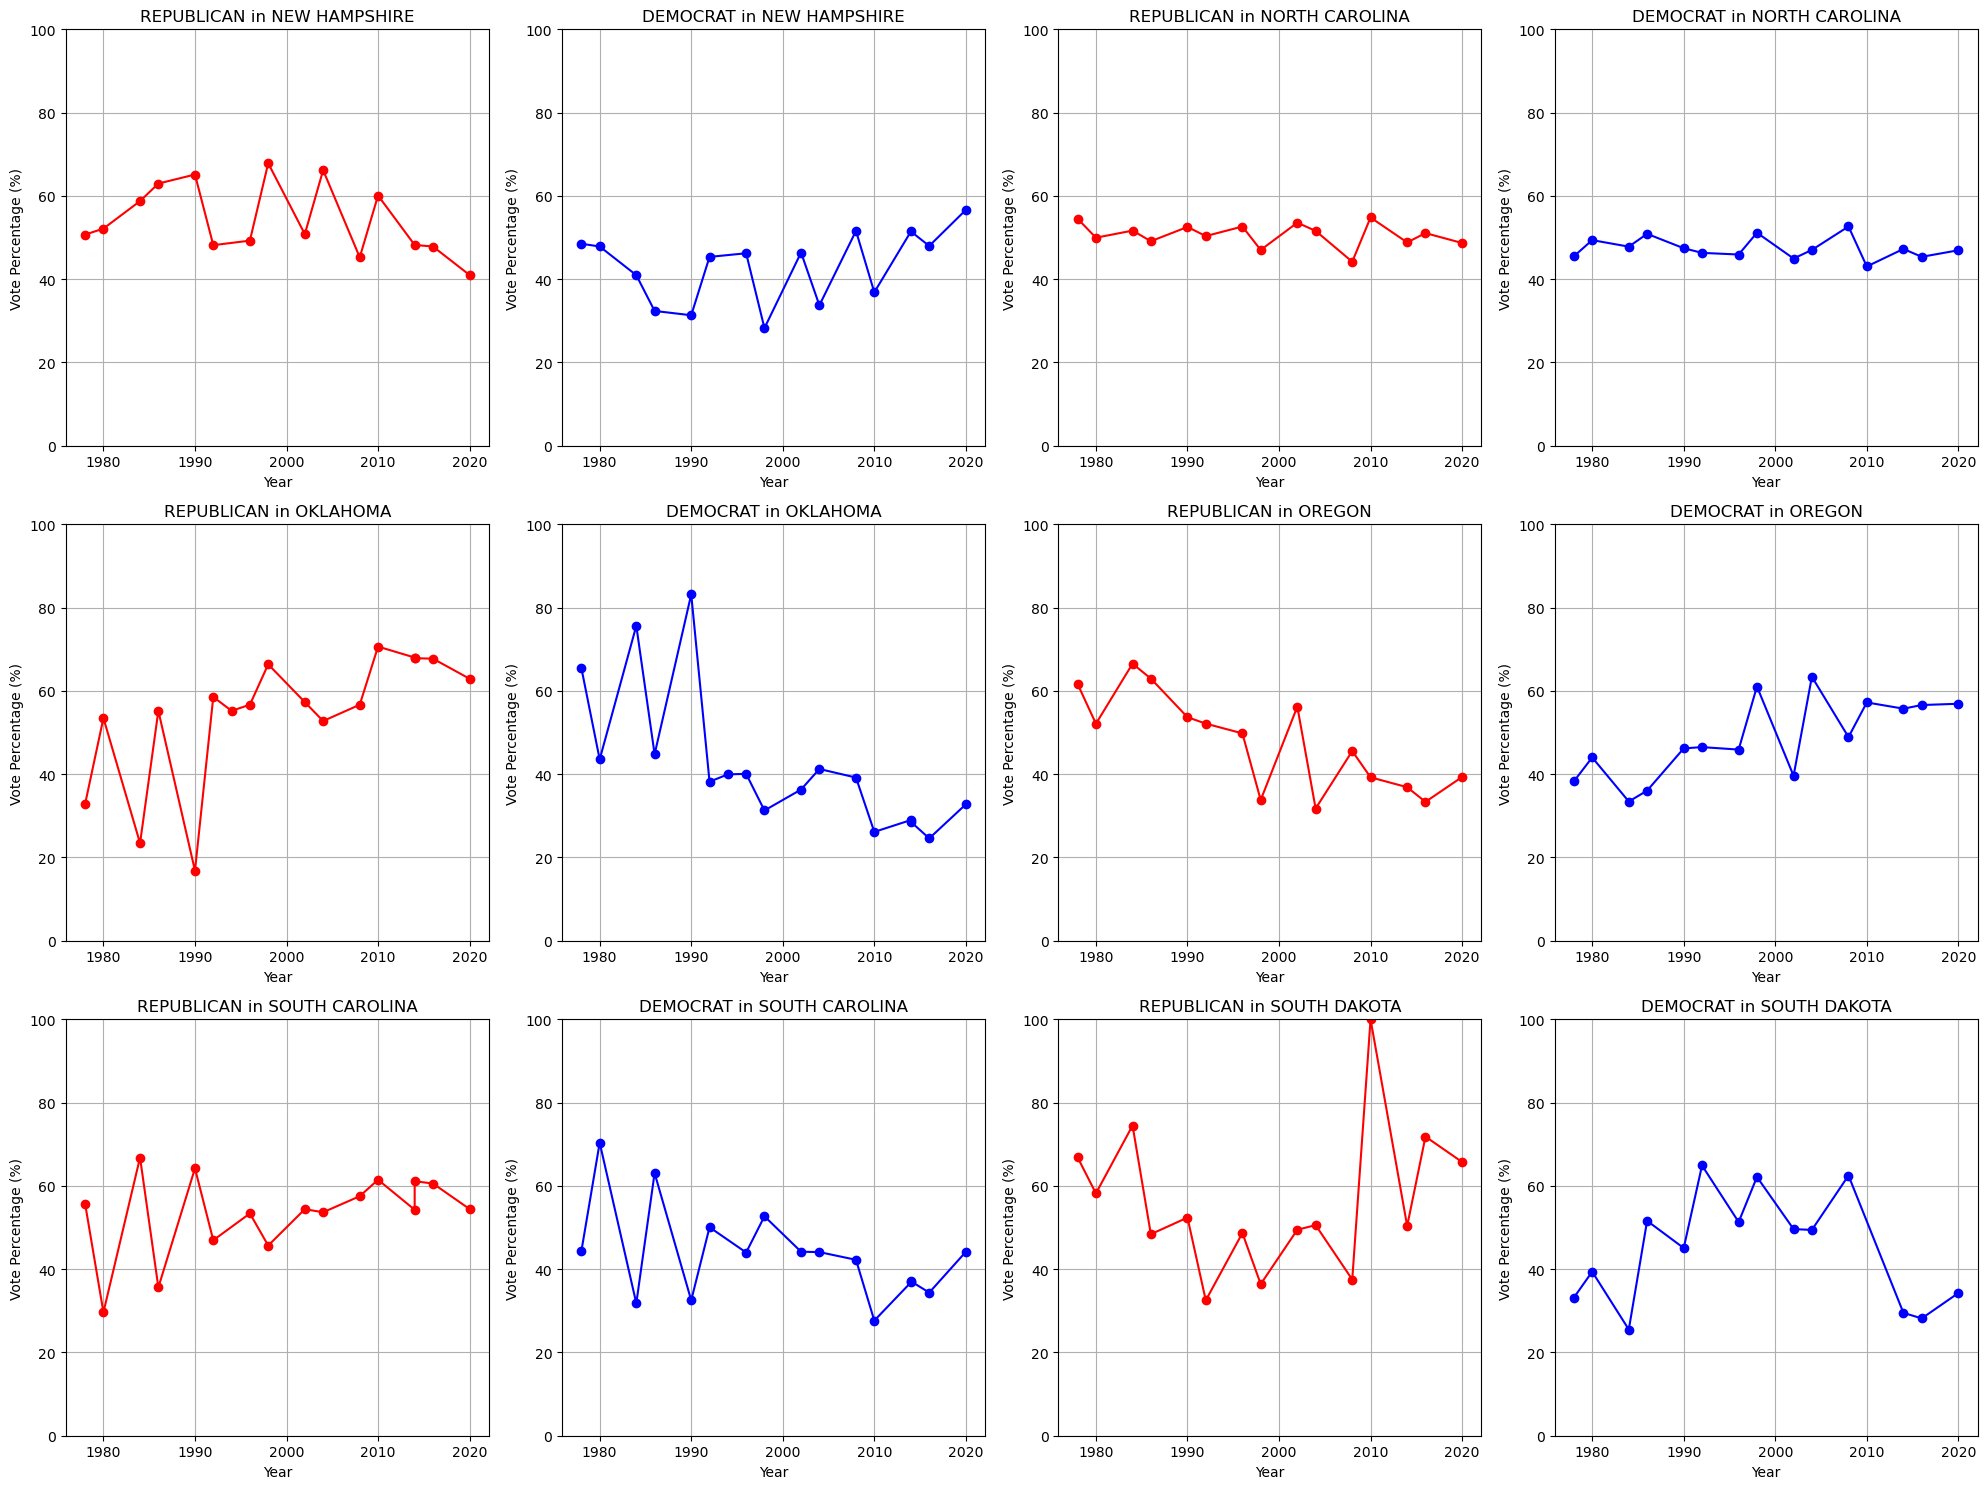

In [48]:
states = filtered_df['state'].unique()
party_order = ['REPUBLICAN', 'DEMOCRAT']
colors = {'REPUBLICAN': 'red', 'DEMOCRAT': 'blue'}
df_dict = {}
num_plots = len(states) * len(party_order)
cols = 4  # Number of columns in the grid
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

plot_index = 0
for state in states:
    for party in party_order:
        state_party_data = df[(df['state'] == state) & (df['party_simplified'] == party)]
        state_party_data = state_party_data[state_party_data['writein'] == False]
        df_dict[(state, party)] = state_party_data
        if not state_party_data.empty:
            ax = axes[plot_index]
            ax.plot(state_party_data['year'], state_party_data['candidatevotes'] / state_party_data['totalvotes'] * 100, marker='o', color=colors[party])
            ax.set_title(f'{party} in {state}')
            ax.set_xlabel('Year')
            ax.set_ylabel('Vote Percentage (%)')
            ax.set_ylim(0, 100)
            ax.grid(True)
            plot_index += 1

# Hide unused subplots
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [53]:
cols = ['year', 'candidatevotes', 'totalvotes']
df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')][cols]

,year,candidatevotes,totalvotes
221,1978,133745,263760
346,1980,195559,375060
607,1984,225828,384369
719,1986,154090,244735
956,1990,189792,291393
1100,1992,249591,518170
1415,1996,242257,491873
1568,1998,213477,314696
1905,2002,227229,447135
2059,2004,434847,657086


In [54]:
def sir_model(t, y, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [57]:
def fit_sir_model(t, beta, gamma, S0, I0, R0):
    sol = solve_ivp(sir_model, [t[0], t[-1]], [S0, I0, R0], t_eval=t, args=(beta, gamma))
    return sol.y[1] 

In [58]:
year = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['year'].values
votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0
params, covariance = curve_fit(fit_sir_model, year, vote_percentage, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
print(f"Fitted parameters: beta={beta}, gamma={gamma}")

Fitted parameters: beta=0.054379614710691075, gamma=0.03446399147359051


In [60]:
fitted_vote_percentage = fit_sir_model(year, *params)

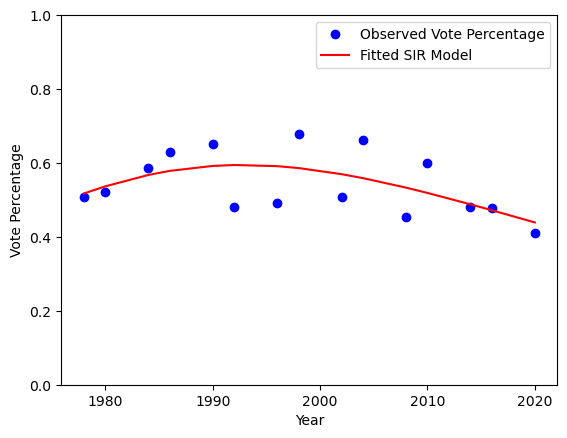

In [62]:
plt.plot(year, vote_percentage, 'bo', label='Observed Vote Percentage')
plt.plot(year, fitted_vote_percentage, 'r-', label='Fitted SIR Model')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.show()